# Newton's law of cooling and neural ordinary differential equations (NODEs) 

In [27]:
using OrdinaryDiffEq, Lux, Random, ComponentArrays, Plots, LaTeXStrings
using SciMLSensitivity, Optimization, OptimizationOptimJL, LineSearches, Zygote, OptimizationFlux, LinearAlgebra

In this example we are going to study **Newton's law of cooling**. Hence, we assume a simple (linear) ODE in the form of $$\frac{\mathrm{d}}{\mathrm{d}t}x(t) = -k (x(t)-\vartheta_\mathrm{A}), \quad x_0 = x(t=0)$$ where $x(t)$ is the temperature of a solid body placed in an ambient fluid (e.g., air) having a constant temperature $\vartheta_\mathrm{A})$. Hence, given a thermal conductivity $k$ and initial body temperature $x_0$ the body temperature will converge toward the ambient temperature. 

In [2]:
function newtons_cooling(dx, x, w, t)
    temp = x[1]
    k, temp_m = w
    dx[1] = -k * (temp - temp_m)
end;

First, we are going to generate some ground truth data including a mild measurement noise.

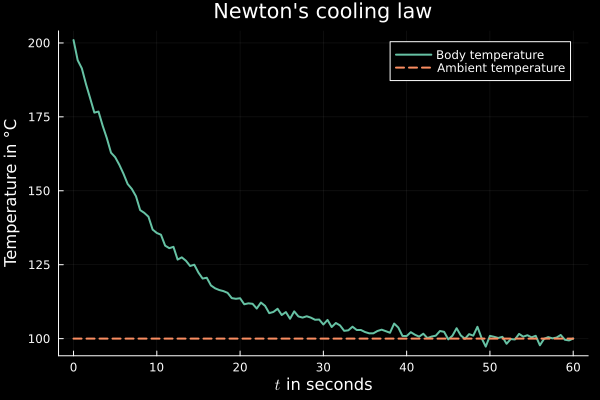

In [3]:
# Define true parameter vector and initial condition
w = [0.1, 100]  # w[1] = Thermal conductivity, w[2] = Ambient temperature
x0 = [200]      # Initial temperature
dt = 0.5        # Time step

# Execute simulation
tspan = (0.0, 60.0)
prob = ODEProblem(newtons_cooling, x0, tspan, w)
sol = solve(prob, Tsit5(), saveat=dt)
t = sol.t
x = x = reduce(vcat,sol.u)  

# Add some noise
Random.seed!(1234)
y = x .+ 1.0*randn(size(x))

# Plot the data
plot(t, y, xlabel = L"$t$ in seconds", ylabel="Temperature in °C", 
     title="Newton's cooling law", background_color="#000000",lw=2, 
     palette = :Set2_5, label = "Body temperature")
plot!(t, w[2]*ones(size(t)), lw=2, linestyle=:dash, label="Ambient temperature")

To study the data-driven modeling approach via **neural ordinary differential equations (NODEs)**, we assume to have no structural knowledge about the ODE's right-hand side. Hence, we replace the entire right-hand side using a simple feedforward artificial neural network (ANN): $$ \frac{\mathrm{d}}{\mathrm{d}t}\hat{x}(t) = \hat{f}_w(x(t), \vartheta_\mathrm{A}).$$ 
The only pre-knowledge we apply to the right-hand side is that it will depend both on the current body temperature $x(t)$ and the ambient temperature $\vartheta_\mathrm{A}$ which is considered a simple constant in this example. Consequently, the ANN representing the ODE has two inputs $(x(t), \vartheta_\mathrm{A})$ and one output $\frac{\mathrm{d}}{\mathrm{d}t}\hat{x}(t)$.

In [4]:
# Set up ANN structure and export randomly initialized parameters to variable params
ann = Lux.Chain(Lux.Dense(2, 10), Lux.Dense(10, 10), Lux.Dense(10, 1));
p, st =Lux.setup(MersenneTwister(140588), ann);
params = ComponentArray(p);

In [5]:
# Define NODE simulation parameters in Float32 (aka single precision) as this is the Lux default
NF = Float32 
x0_NODE = [NF.(y[1])]
tspan_NODE = NF.(tspan)
datasize = Int(tspan_NODE[2]/dt+1)
tsteps_NODE = range(tspan_NODE[1], tspan_NODE[2]; length=datasize); 

In contrast to the previous ground truth data simulation, we need to define the NODE in an out-of-place form (cf. https://docs.sciml.ai/DiffEqDocs/stable/basics/problem/#In-place-vs-Out-of-Place-Function-Definition-Forms) as the in-place formulation does not work with algorithmic differentiation required for the later model optimization. 

In [6]:
dxdt(x, p, t) = ann([x; NF.(w[2])], p ,st)[1] # Define NODE's right-hand side (ANN with two inputs)
prob_NODE = ODEProblem(dxdt, x0_NODE, tspan_NODE, params) # Define NODE problem

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 60.0f0)
u0: 1-element Vector{Float32}:
 200.97066

In [7]:
# Define simulation function which solves the NODE problem for an ANN parameter set w and returns the solution in time 
function predict_NODE(w)
    Array(solve(prob_NODE, Tsit5(); p = w, saveat = tsteps_NODE, dt, adaptive=false))
end;

Based on this NODE definition, we want to optimize $$\begin{gather}\mathcal{L}(w)=\sum_{k=1}^N \|x[k]-\hat{x}[k]\|_2^2 \\ \mathrm{s.t.} \quad \frac{\mathrm{d}}{\mathrm{d}t}\hat{x}(t) = \hat{f}_w(x(t), \vartheta_\mathrm{A}), \quad t_{k}=k*\Delta t.\end{gather}$$

In [8]:
# Define quadratic loss function which compares NODE solution with data and returns the loss
target = NF.(y)
function loss_NODE(w)
    pred = predict_NODE(w)
    loss = sum(abs2, target .- pred) 
    return loss
end;

Next, we formulate the optimization function using the [Optimization.jl](https://github.com/SciML/Optimization.jl) package including algorithmic differentiation via [Zygote.jl](https://fluxml.ai/Zygote.jl/stable/).

In [9]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((w, p) -> loss_NODE(w), adtype)
optprob = Optimization.OptimizationProblem(optf, params)

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = (weight = Float32[0.1474113 -0.34090427; -0.4765873 0.16255365; … ; 0.31245482 -0.22692452; 0.39007953 0.26978415], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.43157503 -0.4646943 … 0.010896199 0.52040297; 0.35209662 -0.30399612 … 0.31160805 0.44783327; … ; -0.5429868 -0.29681996 … -0.21239597 -0.5246462; 0.43584862 0.37372094 … -0.53044903 0.2080397], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.41433412 0.1283959 … -0.14265323 -0.04654335], bias = Float32[0.0;;]))

As we have finished formulating our NODE modeling problem, we try to fit the ANN's parameters minimizing the simulation loss.

In [10]:
try
    res = Optimization.solve(optprob, BFGS(; initial_stepnorm=0.1, linesearch=LineSearches.BackTracking());   maxiters=500)
catch e
    println(e)
end

MethodError(Optim._init_identity_matrix, ((layer_1 = (weight = Float32[0.21138003 -0.34009603; -0.420947 0.16325668; -0.25900993 0.013016731; 0.32293144 -0.3916709; -0.44075826 -0.5561277; -0.07892716 -0.2997011; 0.5363283 -0.33756045; -0.2514592 0.10889916; 0.29854262 -0.2271003; 0.3446387 0.26921], bias = Float32[8.082485f-6; 7.0301844f-6; 1.2552741f-6; 4.9941896f-6; 6.307833f-6; -1.6818435f-6; 2.6172124f-6; -3.6923577f-6; -1.7578135f-6; -5.7414754f-6;;]), layer_2 = (weight = Float32[0.42530558 -0.44390476 -0.3493774 -0.44193497 -0.3452971 0.13501729 -0.2548856 0.13233964 -0.002666981 0.50316405; 0.3501538 -0.29755375 0.3882176 0.17906378 0.4589597 0.3557263 -0.06393171 0.41967496 0.30740502 0.4424912; -0.46473756 -0.28967622 0.50212336 0.19538985 -0.3827906 0.47469825 0.10588671 0.48245707 0.21389477 0.30299085; 0.5065029 0.4985555 0.26788622 -0.09147997 0.50629246 -0.08444813 -0.1382194 0.29238424 0.4160451 0.079570584; 0.5237444 -0.2983727 -0.44743162 0.34256464 -0.11262578 -0.476

As can be seen above, the optimization failed. The root cause for this is that during an update step of the BFGS solver a candidate parameter vector is evaluated which resulted in a **numerically unstable ODE** throwing *Inf* costs. To address this problem, we switch to the [ADAM solver](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) which takes smaller update steps and is less likely to encounter a numerically unstable ODE behavior.  

In [11]:
res = Optimization.solve(optprob, Adam();   maxiters=1000)

u: ComponentVector{Float32}(layer_1 = (weight = Float32[0.1474113 -0.34090427; -0.4765873 0.16255365; … ; 0.31245482 -0.22692452; 0.39007953 0.26978415], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.43157503 -0.4646943 … 0.010896199 0.52040297; 0.35209662 -0.30399612 … 0.31160805 0.44783327; … ; -0.5429868 -0.29681996 … -0.21239597 -0.5246462; 0.43584862 0.37372094 … -0.53044903 0.2080397], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.41433412 0.1283959 … -0.14265323 -0.04654335], bias = Float32[0.0;;]))

Apparently, this optimization run was executed successfully and we did not observe a failing ODE solver. Hence, let's visualize the found NODE model of the Newton's cooling problem. 

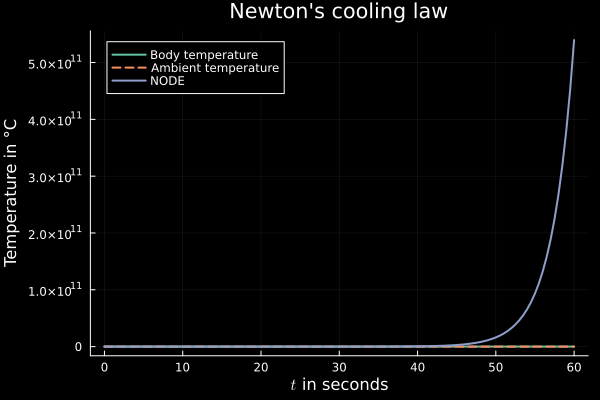

In [12]:
# Plot the data
plot(t, y, xlabel = L"$t$ in seconds", ylabel="Temperature in °C", 
     title="Newton's cooling law", background_color="#000000",lw=2, 
     palette = :Set2_5, label = "Body temperature")
plot!(t, w[2]*ones(size(t)), lw=2, linestyle=:dash, label="Ambient temperature")
plot!(t, predict_NODE(res.u)', label="NODE", lw=2)

Although the model optimization using ADAM did not crash, the found result is practically unstable, that is, the brute force NODE modeling approach was not successful!  

### Remdey no. 1: limit right-hand side ANN's output using suitable activation functions 

In [13]:
# Set up ANN structure with tanh() activation functions
_ann = Lux.Chain(Lux.Dense(2, 10, tanh), Lux.Dense(10, 10, tanh), Lux.Dense(10, 1, tanh)); 
_p, _st =Lux.setup(MersenneTwister(140588), _ann);
_params = ComponentArray(_p);

In [14]:
_dxdt(x, p, t) = _ann([x; NF.(w[2])], p , _st)[1] # Define NODE's right-hand side (ANN with two inputs)
_prob_NODE = ODEProblem(_dxdt, x0_NODE, tspan_NODE, _params); # Define NODE problem

In [15]:
# Define simulation function which solves the NODE problem for an ANN parameter set w and returns the solution in time 
function _predict_NODE(w)
    Array(solve(_prob_NODE, Tsit5(); p = w, saveat = tsteps_NODE, dt, adaptive=false))
end;

In [16]:
# Define quadratic loss function which compares NODE solution with data and returns the loss
function _loss_NODE(w)
    pred = _predict_NODE(w)
    loss = sum(abs2, target .- pred) 
    return loss
end;

In [17]:
_optf = Optimization.OptimizationFunction((w, p) -> _loss_NODE(w), adtype)
_optprob = Optimization.OptimizationProblem(_optf, _params);

In [18]:
_res = Optimization.solve(_optprob, BFGS(; initial_stepnorm=0.1, linesearch=LineSearches.BackTracking());   maxiters=500);

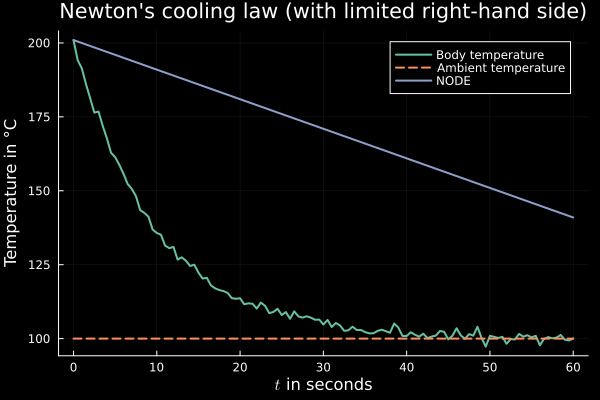

In [19]:
# Plot the data
plot(t, y, xlabel = L"$t$ in seconds", ylabel="Temperature in °C", 
     title="Newton's cooling law (with limited right-hand side)", background_color="#000000",lw=2, 
     palette = :Set2_5, label = "Body temperature")
plot!(t, w[2]*ones(size(t)), lw=2, linestyle=:dash, label="Ambient temperature")
plot!(t, _predict_NODE(_res.u)', label="NODE", lw=2)

### Remedy #3: Perform standardization on NODE data

In [20]:
using StatsBase
dty = fit(ZScoreTransform, y) # Generate a standardization transform for the data
_y = StatsBase.transform(dty, y); # Apply the transform to the data
_ϑ_A = StatsBase.transform(dty, [w[2]]); # Apply same transform to ambient temperature

In [21]:
_dxdt_norm(x, p, t) = _ann([x; NF.(_ϑ_A)], p , _st)[1] # Define NODE's right-hand side with transformed input
_prob_NODE_norm = ODEProblem(_dxdt_norm, StatsBase.transform(dty,x0_NODE), tspan_NODE, _params); # Define NODE problem with transformed initial condition

In [22]:
function _predict_NODE_norm(w)
    Array(solve(_prob_NODE_norm, Tsit5(); p = w, saveat = tsteps_NODE, dt, adaptive=false))
end;

We have transformed the entire NODE into the standardized space. Hence, we need to adapt the loss function accordingly.

In [23]:
target_norm = StatsBase.transform(dty, target);
function _loss_NODE_norm(w)
    pred = _predict_NODE_norm(w)
    loss = sum(abs2, target_norm .- pred) 
    return loss
end;

In [24]:
_optf_norm = Optimization.OptimizationFunction((w, p) -> _loss_NODE_norm(w), adtype)
_optprob_norm = Optimization.OptimizationProblem(_optf_norm, _params);

In [25]:
_res_norm = Optimization.solve(_optprob_norm, Adam();   maxiters=1000)

u: ComponentVector{Float32}(layer_1 = (weight = Float32[0.20563988 -0.31107336; -0.3903999 0.22462688; … ; 0.25182596 -0.26549497; 0.33075967 0.26631558], bias = Float32[-0.029831082; -0.062073313; … ; 0.03857043; 0.003468412;;]), layer_2 = (weight = Float32[0.3869065 -0.4032471 … -0.04037439 0.44743896; 0.31328356 -0.2537578 … 0.26835936 0.39476666; … ; -0.5033949 -0.35067979 … -0.16650677 -0.4640807; 0.4425948 0.36721006 … -0.52184683 0.21553472], bias = Float32[0.006599664; -0.009417896; … ; -0.0018454366; 0.0037092466;;]), layer_3 = (weight = Float32[0.3702334 0.16782108 … -0.109014854 0.042110156], bias = Float32[-0.003821503;;]))

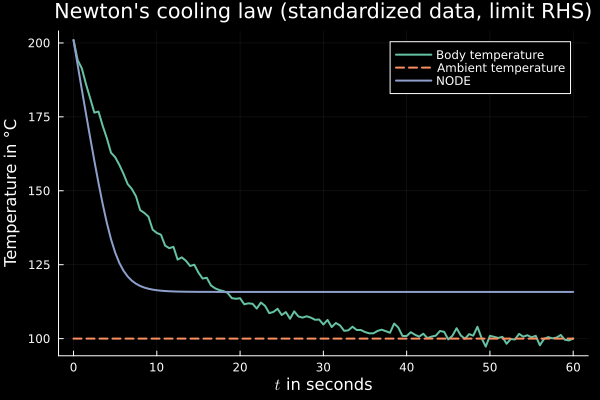

In [26]:
# Plot the data
plot(t, y, xlabel = L"$t$ in seconds", ylabel="Temperature in °C", 
     title="Newton's cooling law (standardized data, limit RHS)", background_color="#000000",lw=2, 
     palette = :Set2_5, label = "Body temperature")
plot!(t, w[2]*ones(size(t)), lw=2, linestyle=:dash, label="Ambient temperature")
plot!(t, StatsBase.reconstruct(dty, _predict_NODE_norm(_res_norm.u)'), label="NODE", lw=2)

Although we could improve the fitted model further, the result is generally poor and depicts a systematic error, although the ground truth problem is quite simple. Hence, this NODE example motivates the need for integrating as much as possible a priori system knowledge and limit the application of function approximators to a minimum. 